## CREAZIONE DELL'AMBIENTE DI LAVORO

#### ACQUISIZIONE DEL DATASET

In [ ]:
import os

# NB: come scritto nel readme questa parte non è fondamentale se ci sono gia' i file
# necessari nella cartella ./data/

# Cambiare le credenziali kaggle per poter scaricare i dati.
# Si uncommenti e si cambino le stringhe con le proprie credenziali.
# os.environ['KAGGLE_USERNAME'] = "your_username"
# os.environ['KAGGLE_KEY'] = "your_password"

# Download di tutti i file .csv presenti nel dataset di instgram.
!kaggle datasets download -p ./data -d bhanupratapbiswas/instgram --unzip 

#### CONTAINER NEO4J

Il container neo4j contiene una empty sandbox con al suo interno le librerie apoc, apoc-extended e gds.
Per fare il build e lo start si deve far girare nella cartella del progetto contente `docker-compose.yml` il comando riportato di seguito.
```bash
sudo docker-compose up
```

Nel caso in cui dovesse riscontrarsi `Error response from daemon: network <id_network> not found` cio' che bisogna fare e' aggiungere una semplice opzione al comando precedente.
```bash
sudo docker-compose up --force-recreate
```

Nel caso invece dovesse riscontrarsi `Cannot connect to the Docker daemon` allora dovete avviare il deamon docker in questo modo:
```bash
systemctl start docker
```
o in maniera analoga con
```bash
sudo systemctl start docker
```

**NB**: Nell'ambiente di visual studio non si riesce, purtroppo, a far girare comandi di questo tipo in modo interattivo (nessuna possibilità di immettere la password).
Si e' anche valutato se metterla in un file .env e richiamarla da riga di comando ma non sarebbe stata sicura in quanto salvata in chiaro. Per questo si richiede all'utente di immeterla da terminale.

Prima di continuare aspettare la conferma dell'avvio del container, come in figura:
![container neo4j](media/container_start.png)

#### CONNESSIONE AL DATABASE

In [ ]:
from neo4j import GraphDatabase as gd

# Prima di arrivare a questo punto si controlli di aver correttamente attivato il container
# Nel caso in cui ci siano dubbi su ip/porta da usare si controlli nel log docker alla voce "bolt"
URI = "bolt://localhost:7688" 

d   = gd.driver(URI, auth=None)
d.verify_connectivity()

#### CREAZIONE DATABASE

In [ ]:
s   = d.session()

# Prova a creare un nuovo database vuoto col nome di instagram.
# Che ci fosse gia' o meno alla fine setta la sessione sul quel database.
# Lo si fa all'inizio per non dover specificarlo ogni volta quando si fanno le query.
try:
    s.run("create database instagram").data() 
except: 
    s = d.session(database="instagram")
finally:
    s = d.session(database="instagram")


Accedendo a http://localhost:7474 e poi con nessuna autenticazione a bolt://localhost:7688 si può:
* controllare che esiste il database instagram
    ```cypher 
    :dbs
* entrare nel database
    ```cypher
    :use instagram

#### CREAZIONE DEI VINCOLI

In [ ]:
# La creazione dei constraint viene fatta per ogni nodo che sara' presente.
# Essi specificano tutti l'unicita' dell'ID.
s.run("create constraint UniqueUserID if not exists for (u:User) require u.id is unique;")
s.run("create constraint UniqueCommentID if not exists for (c:Comment) require c.id is unique;")
s.run("create constraint UniquePostID if not exists for (p:Post) require p.id is unique;")
s.run("create constraint UniqueTagID if not exists for (t:Tag) require t.id is unique;")

# Nel caso in cui il constraint esista gia' non verrà creato nessun errore grazie a 'if not exists'

per controllare che siano stati aggiunti i quattro constraint
```cypher
:schema
```

#### AGGIUNTA NODI

In [ ]:
# Si e' notato che le date di creazione di tag, commenti e post sono tutte 
# allo stesso giorno, cio' vuol dire che non possono essere utilizzate per delle query.
# Si e' deciso quindi di non aggiungerle nei corrispettivi nodi in quanto di poca utilita'.

# Per i nodi user non vengono messe le properties 'post count' 
# e 'verified status' in quanto la prima si puo' ricavare e la seconda 
# non sembra importante per le analisi che si faranno.
s.run('''load csv with headers
         from 'file:///users.csv' as row
         with row merge (u:User{id:toInteger(row.id)})
         on create set
            u.name = row.name,
            u.created = toString(row.`created time`), 
            u.type = toString(row.`private/public`)''')

s.run('''load csv with headers from 'file:///tags.csv' as row 
         with row merge (t:Tag{id:toInteger(row.id)}) 
         on create set 
            t.text = toString(row.`tag text`), 
            t.location = toString(row.location) ''')

# Per i post non vengono caricati i link in quanto non servono per l'analisi che si fara'.
s.run('''load csv with headers from 'file:///photos.csv' as row 
         with row merge (p:Post{id:toInteger(row.id)}) 
         on create set
            p.filter = toString(row.`Insta filter used`),
            p.type = toString(row.`photo type`) ''')

s.run('''load csv with headers from 'file:///comments.csv' as row 
         with row merge (c:Comment{id:toInteger(row.id)}) 
         on create set
            c.text = toString(row.comment) ''')

#### AGGIUNTA RELAZIONI

In [ ]:
# Creazione post da parte di uno user
s.run('''load csv with headers from 'file:///photos.csv' as row 
         match (p:Post{id:toInteger(row.id)})
         match (u:User{id:toInteger(row.`user ID`)}) 
         merge (p)<-[:POSTED]-(u) ''') 

# Tag contenuto in un post.
# La relazione tra tag e user può essere ricavata da user -> post -> tag.
s.run('''load csv with headers from 'file:///photo_tags.csv' as row 
         match (p:Post{id:toInteger(row.photo)})
         match (t:Tag{id:toInteger(row.`tag ID`)}) 
         merge (p)-[:HAS_TAG]->(t) ''') 

# Like di uno user su un post,
# 'created time' e' stato fabbricato e non viene quindi preso in considerazione,
# 'following or not' si può invece ricavare.
s.run('''load csv with headers from 'file:///likes.csv' as row 
         match (p:Post{id:toInteger(row.photo)})
         match (u:User{id:toInteger(row.`user `)}) 
         merge (p)<-[:LIKE {type: row.`like type`}]-(u) ''') 

# Relazione di seguace-seguito, l'arco e' diretto dal follower al seguito.
# Le properties 'is follower active' e 'followee Acc status' non sono fondamentali
# e possono essere ricavate dalle varie relazioni e properties gia' salvate.
s.run('''load csv with headers from 'file:///follows.csv' as row 
         match (a:User{id:toInteger(row.follower)})
         match (b:User{id:toInteger(row.`followee `)}) 
         merge (a)-[:FOLLOWS]->(b) ''') 

# Commento relativo ad un post.
s.run('''load csv with headers from 'file:///comments.csv' as row 
         match (c:Comment{id:toInteger(row.id)})
         match (p:Post{id:toInteger(row.`Photo id`)}) 
         merge (p)<-[:COMMENT_ON]-(c) ''') 

# Commento di uno user.
s.run('''load csv with headers from 'file:///comments.csv' as row 
         match (c:Comment{id:toInteger(row.id)})
         match (u:User{id:toInteger(row.`User  id`)}) 
         merge (c)-[:COMMENTED_BY]->(u) ''') 


#### AGGIUNTA INDICI

In [ ]:
# Si sceglie di creare dei text index per tutte le proprieta' dei nodi,
# tutti i campi sono in formato stringa/testuale e non si pensa di aver mai 
# bisogno di alzare le performance di operazioni numeriche (range indexes).
s.run('''create text index for (u:User) on (u.name)''')
s.run('''create text index for (u:User) on (u.type)''')

s.run('''create text index for (t:Tag) on (t.text)''')
s.run('''create text index for (t:Tag) on (t.location)''')

s.run('''create text index for (p:Post) on (p.type)''')

s.run('''create text index for (c:Comment) on (c.text)''')

# Gli indici sugli ID vengono fatti di default quando si creano i vincoli di unicita'.

## INTRODUZIONE

Il data graph che si vuole andare ad analizzare rappresenta una piccola porzione dei nodi e delle interazioni di Instagram. Essa e' un social network in cui vengono postate foto, video, storie e album di foto. Un utente puo' quindi decidere di pubblicare un post oppure anche solo di commentarle  e/o mettere il like a quello di un altro utente. 
Gli utenti possono conoscersi, seguirsi a vicenda, oppure possono decidere di 'followare' l'account di uno che gli sembra interessante.
I vari account si distinguono inoltre tra privati e pubblici, la differenza tra di essi e' che in uno tutto cio' che viene pubblicato viene  solo visto da chi ha il permesso mentre nell'altro chiunque puo' vedere qualunque cosa.

I social sono quindi un buon esempio di grafo e sopra di essi avvengo interazioni interessanti per molti scopi. Si vedra' in questo caso come sono importanti per il commercio e la pubblicita' di molti servizi.

La topologia del grafo viene quindi presentata nella prima parte di EDA.

## EXPLORATORY DATA ANALYSIS

Per visionare lo schema generale del grafo appena creato si puo' lanciare il comando:
```cypher
call db.schema.visualization()
```

Il risultato di questa operazione dovrebbe essere:

![graph](media/graph_schema.png)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

a   = plt.subplots(nrows=1, ncols=2)[1]

res = s.run('''match (p:Post) return p.type''').data()
pd.DataFrame(res).value_counts().plot(ax=a[0], y="type", kind="pie", autopct='%1.0f%%')

res = s.run('''match (u:User) return u.type''').data()
pd.DataFrame(res).value_counts().plot(ax=a[1], y="type", kind="pie", autopct='%1.0f%%')

# Si nota come per i post sia piu' ricorrente fare foto rispetto a video e carousel
# questo potrebbe essere dato dal fatto che sono gli utenti piu' attivi generano tanti 
# tipi di contenuti mentre quelli meno attivi generano quasi solo foto.

# Per la tipologia di utente (yes=private, no=public) non vi è alcuna differenza.
# Non viene spiegato perfettamente il significato di yes/no nel csv di partenza
# ma si e' interpretato dal nome della proprieta' private/public = yes/no.

In [ ]:
# Proviamo a dare una risposta all'ipotesi avanzata nel precedente commento.
res = s.run('''match (p:Post)<-[:POSTED]-(u:User) 
            return u.type as user_type, p.type as post_type''').data()

pd.DataFrame(res).value_counts().plot(y="post_type", kind="pie", autopct='%1.0f%%')

# Come si può vedere dal grafico, il numero di foto create da utenti privati e non è in ugual misura.
# Per quanto riguarda invece i contenuti sia video che reel la percentuale è maggiore
# per utenti pubblici che privati.
# Come esperienza personale si pensa che gli utenti privati possano essere coloro che sono meno
# incentivati alla creazione in quanto in un ambiente di persone che gia' si conosco e per cui e' piu' 
# semplice mandare direttamente foto e video. O comunque che chi si mette un profilo privato 
# sia intenzionato solo a visionare contenuti piu' che produrli.

In [ ]:
# Per completare la visualizzazione delle properties piu' importanti
# aggiungiamo il grafico sulle percentuali delle location taggate.
res = s.run('''match (t:Tag) return t.location''').data()
pd.DataFrame(res).value_counts().plot(y="location", kind="pie", autopct='%1.0f%%')

Quello che si potrebbe provare a estrapolare da questi ultimi dati è che il dataset rispecchia in piccola parte i veri dati di instagram dei post per continente.
Questa teoria viene in parte provata da alcuni dei grafici di questo [studio](https://mention.com/en/reports/instagram/instagram-report-location/).

Il numero di post maggiori e' dato da regioni USA e questo spiega come mai NYC, Florida e Washington siano 
ad una percentuale cosi alta nel nostro dataset. Queste regioni vengono seguite dal Brasile per cui prova anche la seconda percentuale migliore.
Altro dato interessante e' quello che prova la posizione cosi alta di Londra, essa e' la citta' con 
maggior numero di post, prima anche tra le citta' inglesi.
Inoltre si può notare come i continenti di Asia e Oceania hanno valori molto bassi rispetto a tutti gli altri, questo spiega come mai Australia abbia la percentuale minore. Non spiega come mai Giappone sia a parimerito con Brasile che abbiamo detto essere la seconda country per numero di post.
Infine si noti come la citta' con piu' alto tasso di interazione è stata Mumbai che verosimilmente occupa
la seconda percentuale migliore nel nostro grafico.
L'unico dato che non si riesce bene a ricostruire sembra quindi essere Bangalore.

Sfortunatamente non si può fare una predizione completa in quanto il dataset usato non riporta sicuramente  tutti i dati e si scosta quindi da quello che sarebbe il dataset reale di Instagram.

In [ ]:
# Continuando con l'esplorazione dei dati cerchiamo di capire come solitamente 
# uno user reagisce ad un post (tipo di emoji usato).
res = s.run('''match (u:User)-[r:LIKE]->() with r.type as tipo, u, count(*) as degree
         return tipo, min(degree) as min, max(degree) as max, 
         avg(degree) as average, stdev(degree) as stdev order by tipo''').data()
df  = pd.DataFrame(res)
print(df)

df.drop(columns='tipo').T.boxplot()

# Thumbs up, heart, fire e laughing sono solitamente gli emoji piu' conosciuti 
# e usati anche su altre piattaforme quindi e' verosimile che sono anche quelli piu' gettonati.
# Il boxplot di questi e' positivamente skew in quanto vengono usati spesso.

## RESEARCH QUESTIONS

#### PREDIZIONE DI UNO USER IN VACANZA

Questa domanda si pensa possa essere utile per due motivi:

* Si vuole far capire l'importanza di non lasciare in rete alcune informazioni (anche implicite, cioe' che possano essere derivate) in quanto utenti maligni potrebbero usarle a proprio favore. In questo caso si pensi a come una banda di ladri potrebbe usare l'informazione per andare a svaligiare casa sapendo dove abita la vittima e che questa sia in vacanza.

* Capire se si possono consigliare posti da visitare o in cui comprare. Lo scopo e' quindi commerciale.

Inanzitutto si ragiona con che dati si potrebbe risolvere la domanda.
Con la semplice location si potrebbe ipotizzare che basti sapere il numero di post di un utente per una data regione. 
Si pensa che l'utente medio possa fare molte foto e video di una vacanza ma meno del posto in cui abita e vive, questo perche' e' piu' interessato a ricordarsi momenti che rivivra' difficilmente. 
Quindi cerchiamo una location con percentuale maggiore per predire se rappresenta una location di vacanza.

In [ ]:
from matplotlib import pyplot

# In questo caso e' comodo avere una cypher projection per ogni nodo user che ha postato una foto con
# un certo tag (al cui interno si trova la proprieta' della location).
# Viene usata la cypher in quanto ci permette di modellare in modo piu' flessibile la relazione che
# che si vuole studiare.
s.run('''match (source:User)-[:POSTED]->(:Post)-->(target:Tag)
      with gds.graph.project('posted', source, target) as g
      return g.graphName, g.nodeCount, g.relationshipCount''')

res = s.run('''call gds.graph.relationships.stream('posted')
        yield sourceNodeId as u, targetNodeId as t
        with gds.util.asNode(u).name as user, collect(gds.util.asNode(t).location) as locs
        return distinct user, apoc.coll.frequencies(locs) as locations order by user''').data()

df = pd.DataFrame(res)

print(df.shape) # Come si può notare non tutti i 100 user hanno postato qualcosa.

([<matplotlib.patches.Wedge object at 0x74d6ecd05820>, <matplotlib.patches.Wedge object at 0x74d6f06cdac0>, <matplotlib.patches.Wedge object at 0x74d6ecd05c10>, <matplotlib.patches.Wedge object at 0x74d6ecd05580>, <matplotlib.patches.Wedge object at 0x74d6ee419f70>, <matplotlib.patches.Wedge object at 0x74d6ee41b350>, <matplotlib.patches.Wedge object at 0x74d6ee41b380>], [Text(0.8468932598760948, 0.70197706969419, 'london'), Text(-0.532693918560852, 0.9624121721634056, 'brazil'), Text(-1.0999999999999892, -1.5448414893833034e-07, 'australia'), Text(-0.8209711704763503, -0.7321245367058062, 'bangalore'), Text(-0.14517273892689647, -1.0903783177743693, 'washington DC'), Text(0.5840679438677552, -0.9321290881343061, 'florida'), Text(1.0381198976323982, -0.36374039937804425, 'Mumbai')], [Text(0.4619417781142334, 0.3828965834695582, '22%'), Text(-0.2905603192150102, 0.524952093907312, '22%'), Text(-0.5999999999999941, -8.426408123908927e-08, '12%'), Text(-0.44780245662346374, -0.39934065638

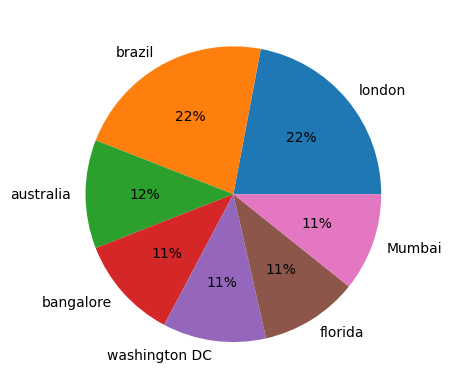

In [35]:
# Usiamo il primo user (Adelle96) come esempio per capire quali location ha maggiormente usato.
# Per fare questo creaiamo prima di tutto una relazione ad-hoc uguale a quella di posted ma 
# con al suo interno.
s.run('''match (source:User {name: 'Adelle96'})-[:POSTED]->(:Post)-->(target:Tag)
      with gds.graph.project('adelle', source, target) as g
      return g.graphName, g.nodeCount, g.relationshipCount''')

# Per poter capire quali siano i luoghi piu' postati da Adelle96 usiamo l'algoritmo di pageRank.
# Dato che i valori di location non sono univoci nel grafo si deve, alla fine della query, 
# unire gli score risultati per location uguali (se no ci si ritrova con, ad esempio, due luoghi NYC).
# Anche per questo si e' deciso di usare questo algoritmo, per calcolare lo score conta il numero
# di relazioni entranti e quindi possiamo semplicemente sommare i risultati di location uguali.
res = s.run('''call gds.pageRank.stream('adelle')
            yield nodeId as id, score with gds.util.asNode(id) as node, score as score
            where labels(node) = ['Tag']
            return distinct node.location as location, sum(score) as score order by score desc''').data()
df = pd.DataFrame(res)
print(pyplot.pie([float(v) for v in df['score']], labels=[str(k) for k in df['location']], autopct='%1.0f%%'))

Come si nota dal grafico il maggior numero di foto viene da Londra e Brasile. L'interpretazione che si potrebbe dare e' che l'utente abbia fatto due vacanze distinte in queste due regioni. Ovviamente Instagram potrebbe verificare che l'ipotesi sia vera in quanto sul profilo puo' essere inserita la nazionalita'.
Inoltre, se si avessero i timestamp di quando sono stati postati i contenuti, si potrebbe affermare anche se lo user e' attualmente in quel posto. 
In ogni caso per questioni pubblicitarie non serve saper individuare una vacanza o meno dato che basterebbe consigliare i servizi del posto in cui si e' correntemente. Ad esempio se l'utente stesse postando da qualche giorno le foto dell'australia si potrebbe provare a consigliarli di visitare l'Ayers rock.

Per quanto riguarda la problematica di un utente maligno si puo' dire che non si riesce a ricavare un modo automatico per calcolare se l'utente non e' a casa, questo perchè le uniche analisi che si possono fare direttamente con instagram sembrano essere solo relative al proprio account. 
L'unica maniera per l'utente maligno sarebbe quindi quella di controllare manualmente un utente target che abiti nella sua zona e vedere quando vengono creati dei post taggati in un luogo diverso.
Sicuramente un modo per potersi proteggere da questa possibilita' potrebbe essere il mantenere l'account privato cosi da evitare che persone estranee possano 'spiare' i nostri post.
Un altro modo potrebbe anche essere il non mettere la nostra nazionalita' o non taggare la localita'che si sta visitando.

In [36]:
# Si potrebbe ora rafforzare le ipotesi cercando quali tra i post dell'utente hanno come tag
# beach e landscape.
# La teoria si basa sul fatto che si pensa che fare foto o video di una spiaggia o di un paesaggio 
# siano piu' comuni quando si e' in un posto nuovo e non quando si e' in uno che gia' si conosce come
# il paese/citta' di abitazione.
res = s.run('''call gds.graph.relationships.stream('adelle')
            yield sourceNodeId as u, targetNodeId as t
            return distinct gds.util.asNode(t).location as loc, 
            collect(distinct gds.util.asNode(t).text) as tags''').data()

# Per poter gia' filtrare per tipo di tag si puo' aggiungere in and nella clausola where
# (t.text = 'beach' or t.text = 'landscape')

print(pd.DataFrame(res))

# Il risultato mostra che a Londra l'utente ha probabilmente visitato una spiaggia, il che 
# vorrebbe dire che la sua potrebbe essere stata effettivamente una vacanza.
# Per invece Brasile si puo' dire ben poco.
# Come si e' pero' detto se avessimo la provenienza degli user si potrebbe provare quanto 
# la teoria possa essere valida.

             loc            tags
0      bangalore        [beauty]
1      australia         [smile]
2         london  [beach, happy]
3        florida      [stunning]
4  washington DC        [dreamy]
5         brazil     [fun, food]
6         Mumbai     [delicious]


In [37]:
# In quanto non e' detto che Adelle96 sia andata in vacanza da sola possiamo
# controllare se ci sono altre persone che sono state negli stessi posti e con tag simili.
# Questa operazione puo' essere utile per poter consigliare le stesse pubblicita' ad utenti 
# che hanno avuto esperienze simili.
# Si valutano tutte le similarita' con user1 = Adelle96 in quanto se lei fosse lo user2 il valore sarebbe
# lo stesso, la matrice di similarita' e' simmetrica.
# Inoltre mettiamo un Cutoff al valore della similirita' che dovra' quindi essere almeno 0.5.
# Questo viene fatto perche' valori inferiori potrebbe portare user diversi che quindi non ci interessano.
res = s.run('''call gds.nodeSimilarity.stream('posted', {similarityCutoff: 0.5})
            yield node1, node2, similarity
            with gds.util.asNode(node1).name as user1, gds.util.asNode(node2).name as user2, similarity as sim
            where user1 = 'Adelle96' return user1, user2, sim order by sim desc''').data()
sim = pd.DataFrame(res)
print(sim)

      user1                  user2       sim
0  Adelle96        Presley_McClure  0.700000
1  Adelle96          Mariano_Koch3  0.636364
2  Adelle96               Gerard79  0.636364
3  Adelle96  Tabitha_Schamberger11  0.583333
4  Adelle96       Ressie_Stanton46  0.555556
5  Adelle96                  Gus93  0.555556
6  Adelle96                Alysa22  0.500000


In [38]:
# Creazione di Adelle96
res = s.run(f'''call gds.graph.relationships.stream('posted')
        yield sourceNodeId as src, targetNodeId as dst
        with gds.util.asNode(src) as u, gds.util.asNode(dst) as t
        where u.name = '{sim['user1'][0]}'
        return distinct u.name as user, collect(distinct t.text) as texts, 
        collect(distinct t.location) as locs''').data()
df = pd.DataFrame(res)

# Aggiunta degli utenti simili
for i in range(len(sim)):
    res = s.run(f'''call gds.graph.relationships.stream('posted')
        yield sourceNodeId as src, targetNodeId as dst
        with gds.util.asNode(src) as u, gds.util.asNode(dst) as t
        where u.name = '{sim['user2'][i]}'
        return distinct u.name as user, collect(distinct t.text) as texts,
        collect(distinct t.location) as locs''').data()

    df.loc[len(df)] = pd.Series(res[0])

# Si stampano i valori delle location in un loop dato che l'output potrebbe venir troncato
# tagliando alcune citta'.
for i in range(len(df)):
    print(df['locs'][i])

# Tutte le persone a parte due sono state sia a londra che in Brasile, questo potrebbe voler dire
# che o Adelle96 ha molti amici con cui va in vacanza (gli stessi sarebbero andati 
# anche in florida, australia e bangalore) o che quei luoghi attraggono maggior turismo e che 
# quindi sia probabile che ci vada molta gente.
# A questo punto per capire una relazione di amicizia servirebbe cercare chi segue Adelle96 che viene
# a sua volta seguito da lei. Il problema e' che il grafo (si vedra' nella prossima research question)
# e' quasi completo quindi sarebbe scontato che quasi tutti gli utenti la seguano e lei li segui a sua 
# volta.


['australia', 'brazil', 'london', 'bangalore', 'Mumbai', 'washington DC', 'florida']
['australia', 'london', 'bangalore', 'brazil', 'japan', 'Mumbai', 'washington DC', 'florida']
['australia', 'brazil', 'florida', 'london', 'new york', 'washington DC']
['australia', 'brazil', 'florida', 'london', 'bangalore', 'new york', 'washington DC']
['australia', 'brazil', 'washington DC', 'new york', 'bangalore', 'london', 'japan', 'Mumbai']
['australia', 'london', 'bangalore', 'washington DC', 'florida']
['australia', 'london', 'bangalore', 'washington DC', 'florida']
['australia', 'brazil', 'washington DC', 'london', 'bangalore', 'florida']


#### COME PUBBLICIZZARSI

Come gia' visto i social vengono usati per pubblicizzare la propria attivita'/azienda.
Diventa quindi importante sapere chi sono le persone piu' importanti nella rete per avere il giusto advertiser.
In questa domanda cerchiamo di capire chi puo' essere quello migliore.

In [ ]:
# Controlliamo come sono distribuiti il numero di follower per user (in degree).
res = s.run('''match (u:User)<-[:FOLLOWS]-() with distinct u.id as user, 
               count(*) as indegree return indegree''').data()

pd.DataFrame(res).hist()

# I valori sono tutti molto vicini tra loro ma, come si vede per range di valori piu' ampi
# su social network graph, riporta molti utenti con valori piu' bassi e pochi con valori alti.
# Si potrebbe avanzare quindi l'ipotesi che gli utenti con valore 77.0 
# siano quelli piu' influenti.

# Controlliamo ora com'e' distribuito il numero di persone seguite per user (outdegree)
res = s.run('''match (u:User)-[:FOLLOWS]->() with distinct u.id as user, 
               count(*) as outdegree return outdegree''').data()

pd.DataFrame(res).hist()
# Quello che si sperava di trovare e' un grafo speculare a quello precedente
# in cui gli utenti piu' seguiti sono quelli che dovrebbe seguire meno.
# Il fatto che e' stato ottenuto questo risultato fa pensare che il grafo possa non rappresentare
# appieno uno small-world come invece sarebbero social di questo tipo.
# Per provarlo bisorrebbe usare l'algoritmo gds.triangleCount sfortunatamente 
# funziona solo su relazioni indirette. 

# Un ulteriore modo per visionare questi risultati e' utilizzare la funzione
# gds.degree.stream().
# Per avere performance migliori durante la ricerca creaiamo prima una proiezione.
# In questo caso ci servono gli utenti e la relazione di following e possiamo usare 
# una native projection per una vista cosi semplice.
s.run('''call gds.graph.project('follows', 'User', 'FOLLOWS')''')

res = s.run('''call gds.degree.stream('follows')
                yield nodeId, score return score, 
                collect(distinct gds.util.asNode(nodeId).name) as user''').data()
print(pd.DataFrame(res))

# Come si puo' notare abbiamo alcuni utenti che non seguono nessuno (ma che probabilemente sono seguiti)
# e altri (la maggior parte) che seguono molte persone.
# Si puo' quindi prevedere che le comunita' che verranno trovate corrisponderanno probabilmente ad 
# un gruppo grande e tanti piccoli che sono gli utenti che non seguono nessuno
print(f'Numero di utenti che non seguono nessuno: {len(res[0]['user'])}')

# Per poter controllare anche il valore di outdegree (utenti piu' seguiti) si puo' usare lo stesso 
# algoritmo ma con gli archi al contrario
res = s.run('''call gds.degree.stream('follows', {orientation: 'REVERSE'})
                yield nodeId, score return score, 
                collect(distinct gds.util.asNode(nodeId).name) as user''').data()
print(pd.DataFrame(res))

Per controllare che la proiezione sia stata creata si può lanciare:
```cypher
call gds.graph.list()
```
**NB**: L'operazione da un warning se eseguita da browser in quanto funzione deprecata, si è stati costretti ad usarla perchè non sono state trovate tecniche alternative per poter visionare tutte le proiezioni. Inoltre nella pagina di [documentazione](https://neo4j.com/docs/graph-data-science/current/operations-reference/graph-operation-references/) non sembra essere riportato il problema.

In [ ]:
res = s.run('''call gds.labelPropagation.stream('follows') yield  nodeId as n, communityId as c 
         return distinct c as community, count(*) as people''').data()

print(pd.DataFrame(res))
# Come si puo' notare le comunita' da 1 solo utente trovate sono 23, esattamente il numero trovato 
# dallo studio di centralita'.

# Il problema pero' dell'algoritmo di labelPropagation e' appunto che propaga un certo id di comunita'
# ed in un grafo cosi denso come quello che si ha e' verosimile che lo stesso label arrivi a 
# molti dei nodi della rete.
# Provando infatti algoritmi che ottimizzano i valori coi quali tagliare il dendrogramma si 
# riceve tutt'altra risposta che e' probabilmente piu' veritiera per un social.
# Il numero delle comunita' pero' cala di uno, da 24 a 23 trovate.

res = s.run('''call gds.modularityOptimization.stream('follows')
        yield nodeId as user, communityId as comm
        return distinct comm, count(distinct user) as users''').data()
print(pd.DataFrame(res).head(5)) 
# Si fanno vedere solo le prime 5 comunita' per evitare un output troppo verboso, se si vuole invece
# visionare per intero si puo' togliere la funzione .head(5)

res = s.run('''call gds.louvain.stream('follows')
        yield nodeId as user, communityId as comm
        return distinct comm, count(distinct user) as users''').data()
#print(pd.DataFrame(res))
# Per visionare che anche l'algoritmo di louvain trova le stesse community rispetto a modularityOpt
# si uncommenti il print sopra.

Volendo si può anche provare un'alternativa alla native projection che è la cypher (ma in questo caso sarebbe molto meno performante):
```python
s.run('''call gds.graph.project.cypher      
    ('follow', 'match (u:User) return u.id as id', 
    'match (a:User)-[r:FOLLOWS]-(b:User)
    return distinct a.id as source, 
    b.id as target, type(r) as type') ''')
```

Ci troviamo in presenza di un grafico molto connesso in cui la maggior parte degli utenti e' connessa con l'altra.
Questo è anche provato dal fatto che usando l'algoritmo di pagerank tutti i nodi hanno valore di score praticamente uguale (0.43) e che la differenza si nota solo dopo la terza cifra decimale.
Come si era detto infatti e' possibile che le comunita' piccole, nonostante non seguano nessuno, vengano seguiti (indegree) dandogli cosi un valore non nullo di pageRank.

In [ ]:
res = s.run('''call gds.pageRank.stream('follows') yield nodeId, score
            return distinct score, count(nodeId) as users''').data()
print(str(pd.DataFrame(res)) + '\n')

# Similmente anche per l'algoritmo di articleRank che funziona in modo simile.
# Esso usa la media degli outdegree al posto del numero degli outdegree.
res = s.run('''call gds.articleRank.stream('follows') yield nodeId, score
            return distinct score, count(nodeId) as users''')
print(pd.DataFrame(res))

In [ ]:
# Per rinforzare l'ipotesi che il grafo sia fortemente connesso controlliamo l'effective diameter
# che è il maggiore degli shortestpath.
# Si sceglie di mettere un massimo alla lunghezza in quanto produrrebbe un warning per le performance.
# Mettiamo il valore 10 perchè se fosse uno small-world tipicamente non si hanno path > 5,
# se fosse un grafo completo il numero sarebbe 1. Quindi per stare larghi decidiamo per 10.
# Ricordiamo che il grafo in questione non e' pesato e che quindi ogni arco ha peso 1.
res = s.run('''match (a:User)-[r]-(b:User) where a.id < b.id
               match p = shortestPath((a)-[*..10]-(b))
               return length(p) as diameter order by diameter desc limit 1''').data()
print(res)

# Un altro modo per trovare il diametro è usando la libreria gds.
# Questo e' probabilmente un migliore utilizzo in quanto rendiamo piu' performante la query
# su di un set finito di nodi e non su tutto il grafo di partenza.
res = s.run('''call gds.allShortestPaths.stream('follows')
        yield distance as cost return max(cost)''').data()
print(res)


# Tutto questo era pero' gia' ipotizzabile solo dalla visione del comando
# che elenca le prime 25 relazioni di follows (foto che segue).
# Come si nota e' abbastanza denso.

![follows](media/follow_relationship.png)

Avendo visto che non sono individuabili degli utenti piu' influenti si decide di trovare un modo diverso per poter farsi pubblicita' (col proprio account aziendale) su un social di questo tipo.

Scegliere il giusto tag per un post e' importante per attirare like e commenti e darsi maggiore visibilita'.
Si puo' quindi ipotizzare che parole come 'fun' o 'food' possano avere un peso maggiore contro quelle come 'drunk' e 'stunning'.

In [ ]:
# Vediamo quanti post ci sono per ogni tipo di tag trovato.
# Come solito creaiamo una proiezione per evitare di sovraccaricare il grafo di partenza 
s.run('''call gds.graph.project('tagged', ['Post', 'Tag'], 'HAS_TAG')''')

res = s.run('''call gds.graph.relationships.stream('tagged')
            yield sourceNodeId as p, targetNodeId as t
            return distinct gds.util.asNode(t).text as text, count(gds.util.asNode(p)) as posts''').data()

df  = pd.DataFrame(res)

print(pyplot.pie([float(v) for v in df['posts']], labels=[str(k) for k in df['text']], autopct='%1.0f%%'))

In [ ]:
# Si nota dal grafico che smile, beach, party e fun sono i tag piu' usati.
# Guardiamo ora quali sono i tag piu' commentati.
s.run('''match (source:Comment)-[]->(:Post)-[]->(target:Tag)
      with gds.graph.project('commented',source, target) as g
      return g.graphName as graph, g.nodeCount as nodes, g.relationshipCount as rels''')

res = s.run('''call gds.graph.relationships.stream('commented')
            yield sourceNodeId as c, targetNodeId as t
            with gds.util.asNode(t).text as tag, gds.util.asNode(c) as comment
            return tag, count(comment) as comments order by comments desc limit 5''').data()

print(pd.DataFrame(res))
# Si nota che i tag piu' commentati sono anche quelli piu' usati dagli utenti.
# Si pone quindi un problema che potra' pero' risolvere solo l'azienda che vuole farsi pubblicita':
# usare tag molto gettonati da' davvero visibilita'? In teoria cercando 'smile' non e' detto che 
# il proprio annuncio esca subito fuori e si rischia che non venga visto.
# Inoltre non sempre un'azienda puo' fare una pubblicita' che riporta uno di questi contesti, ad esempio
# 'beach' non ha molto senso usarlo per un' azienda che vuole sponsorizzare medicinali.

In [ ]:
# Continuiamo pero' con la ricerca e controlliamo quali sono i post con piu' like con un certo tag.
res = s.run('''match ()-[r:LIKE]->(p:Post)-->(t:Tag) return p.id as id, 
      collect(distinct t.text) as tags, count(r) as likes 
      order by likes desc limit 10''').data()

print(pd.DataFrame(res))
# I tag visti prima sono anche quelli nel post con piu' like.
# A esempio 'smile', che aveva la % maggiore di utilizzo , e' anche quello usato
# nei primi 10 post con piu' like.

# Si noti come dalle parole chiavi si possa anche ricostruire che tipo di post
# potesse essere! Ad esempio il post con id 227 e 201 ci fanno pensare ad una foto di una
# spiaggia al tramonto.
# Cio' prova quanto sia importante saper riassumere il proprio post
# in una pubblicita' per richiamare chi potrebbe essere interessato a quegli argomenti.

## CONCLUSIONI

Purtroppo il dataset scelto non e' accurato e non e' sicuramente vicino ad un social network reale, come si e' appurato piu' di una volta.
Nonostante le relazioni di seguace-seguito non dicano granche' abbiamo capito che per scopi pubblicitari ci si puo' servire anche di altri parametri per poter avere piu' visualizzazioni e reaction. Questo e' possibile grazie alla ricerca dei contenuti chiave nella rete.
Si e' quindi capito che per attirare l'attenzione degli utenti bisogna usare le parole chiave migliori, ad esempio non viene usato 'lol' ma 'fun' che probabilmente attira maggiormente. 
Ovviamente per le aziende che vogliono seriamente mettere la loro pubblicita' in gran circolazione conviene anche stipulare degli accordi (pagare) per avere un ranking migliore e quindi apparire piu' frequentemente di altri annunci.

Si e' inoltre giunti alla conclusione che esistono dei dati che potrebbero ricadere in problemi di sicurezza. Ovviamente non si e' suggerito all'utente di non fare un account per evitare suddetti problemi, ma ci si e' concentrati sul quanti e quali tipi di dati possono tracciare l'utente e decretarlo via da casa. Il caso peggiore sarebbe quindi quello di avere un account pubblico in cui si mostra la propria nazionalita' e si postano foto quando si e' in vacanza. 

#### CHIUSURA SESSIONE

In [ ]:
s.close()
d.close()